# ML n DL for Programmers
-------------------------------
### Session III

## Recap

* Summary of v1:
    ![pk_v1](images/pkv1.JPG)

* Trained on 29991 samples, validated on 3333 samples
* **_Total failure_**
    ![pk_V1_Accuracy](images/pkv1accuracy.JPG)

## Bit of thinking

#### Why our model overfitted?

* Trainable params of model is much greater than number of training samples.

* No regularization was used.

## Time for v2
* Decrease number of parameters.
* Increase number of training samples.
* Add dropout to regularize.
* Do batch normalization. 

In [1]:
# Load training data
import gensim.downloader as api
from smart_open import smart_open

text8_path = api.load("text8", return_path=True)
text8_data = ""
with smart_open(text8_path, 'rb') as file:
    for line in file:
        line = line.decode('utf8')
        text8_data += line
text8_data = text8_data.strip()
text8_data = text8_data[:1000000]
print(f'Lenght of Corpus: {len(text8_data)}')

# Prepare dictionaries
chars = sorted(list(set(text8_data)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(f'unique chars: {len(chars)}')

Lenght of Corpus: 1000000
unique chars: 27


In [2]:
# Prepare training data
SEQUENCE_LENGTH = 30
STEP = 3
sentences = []
next_chars = []
for i in range(0, len(text8_data)-SEQUENCE_LENGTH, STEP):
    sentences.append(text8_data[i:i+SEQUENCE_LENGTH])
    next_chars.append(text8_data[i+SEQUENCE_LENGTH])

print(f'number of training sentences: {len(sentences)}')
print(f'2nd sentence: {sentences[2]}')
print(f'char after 2nd sentence: {next_chars[2]}')
print(f'3rd sentence: {sentences[3]}')

number of training sentences: 333324
2nd sentence: ism originated as a term of ab
char after 2nd sentence: u
3rd sentence:  originated as a term of abuse


In [3]:
import numpy as np
from tqdm import tqdm
import pickle

input_sent = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
output_char = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in tqdm(enumerate(sentences)):
    for j, char in enumerate(sentence):
        input_sent[i, j, char_indices[char]] = 1
    output_char[i, char_indices[next_chars[i]]] = 1

# some validations
print(f'shape of input_sent tensor: {input_sent.shape}')
print(f'shape of output_char matrix: {output_char.shape}')

333324it [00:02, 165193.58it/s]

shape of input_sent tensor: (333324, 30, 27)
shape of output_char matrix: (333324, 27)


In [5]:
from keras.models import Sequential
from keras.engine.input_layer import Input
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

model = Sequential()
model.add(Dense(100, input_shape=(SEQUENCE_LENGTH, len(chars)), activation='relu', name='input_layer'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(70, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(chars), activation='softmax', name='output_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 30, 100)           2800      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3000)              12000     
_________________________________________________________________
dense_3 (Dense)              (None, 70)                210070    
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [6]:
# we will use few tricks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
callbacks = [early_stop, reduce_lr]

In [ ]:
# Train 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sent, output_char, validation_split=0.1, batch_size=64, epochs=50, callbacks=callbacks, shuffle=True)

In [ ]:
#save model and its history
model.save('models/predictive_keyboard_v2.h5')
pickle.dump(history.history, open('models/history_pk_v2.p', 'wb'))

In [7]:
# load model back again
from keras.models import load_model
model = load_model('models/predictive_keyboard_v2.h5')
history = pickle.load(open("models/history_pk_v2.p", "rb"))

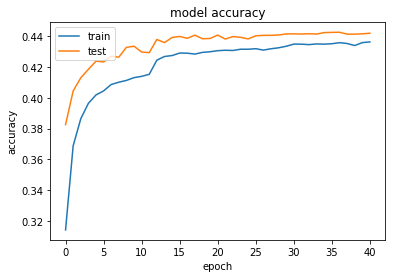

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [9]:
# Prepare test data
test_data = text8_data[-50000:]
test_sentences = []
test_chars = []
for i in range(0, len(test_data)-SEQUENCE_LENGTH, STEP):
    test_sentences.append(test_data[i:i+SEQUENCE_LENGTH])
    test_chars.append(test_data[i+SEQUENCE_LENGTH])

print(f'number of test sentences: {len(test_sentences)}')
print(f'2nd sentence: {test_sentences[2]}')
print(f'char after 2nd sentence: {test_chars[2]}')
print(f'3rd sentence: {test_sentences[3]}')

number of test sentences: 16657
2nd sentence: position to some one or someth
char after 2nd sentence: i
3rd sentence: ition to some one or something


In [10]:
# prepare test input
test_input = np.zeros((len(test_sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
test_label = np.zeros((len(test_sentences), len(chars)), dtype=np.bool)
for i, sentence in tqdm(enumerate(test_sentences)):
    for j, char in enumerate(sentence):
        test_input[i, j, char_indices[char]] = 1
    test_label[i, char_indices[next_chars[i]]] = 1

# some validations
print(f'shape of input_sent tensor: {test_input.shape}')
print(f'shape of output_char matrix: {test_label.shape}')

16657it [00:00, 170453.24it/s]

shape of input_sent tensor: (16657, 30, 27)
shape of output_char matrix: (16657, 27)


In [12]:
model.evaluate(test_input, test_label)

16657/16657 [==============================] - 1s 33us/step


[4.705389934305513, 0.0864501410863004]

In [13]:
# Post processing
import heapq


def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for i, char in enumerate(text):
        x[0, i, char_indices[char]] = 1.
        
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [14]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [16]:
# Test model
test_sent = ["He told us a very exciting adventure story",
             "She wrote him a long letter but he did not read it",
             "The sky is clear black with shining stars",
             "I am counting my calories yet I really want dessert",
             "We need to rent a room for our party"
            ]
for sent in  test_sent:
    sent_4_NN = sent[:30].lower()
    print(sent_4_NN)
    print(predict_completions(sent_4_NN, 5))
    print()

he told us a very exciting adv
['er ', 'iction ', 'and ', 'o ', ' the ']

she wrote him a long letter bu
['t ', 'lth ', 'ch ', 'stre ', 'reation ']

the sky is clear black with sh
['e ', 'at ', 'is ', 'owed ', 're ']

i am counting my calories yet 
['and ', 'the ', 'of ', 'in ', 'seven ']

we need to rent a room for our
[' and ', 'ned ', 's ', 'ous ', 'an ']



## What's else can be improved

* Can we predict next character without having knowledge of what came before.


* Does sequence matter in this case?

## Enter Recurrent Neural Networks(RNN)

#### Limitations of Vanilla NN (Or even ConvNet)
* They accept a fixed-sized vector as input and produce a fixed-sized vector as output.
* These models perform mapping using a fixed amount of computational steps.

In contrast RNN can be used to process sequential data.
Some common use cases:
![rnn use case](images/RNN_usecase.jpeg)

#### Even non-sequence data can be processed in sequence

<table><tr><td><img src='images/rnn_housenumbers.gif'></td><td><img src='images/house_generate.gif'></td></tr></table>

## So how RNN work

* Simple, it takes input tensor `x` and returns output tensor `y`.
* Output tensor’s contents are influenced not only by the input you just fed in, but also on the entire history of inputs you’ve fed in the past. 

So if RNN is a class, then it has only one method, let's say `step`
Then output `y` can be:
```
rnn = RNN()
y = rnn.step(x) # x is an input vector, y is the RNN's output vector
```


##### Where step function is defined as:
```
class RNN:
  # ...
  def step(self, x):
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y
```

##### And if you want to go deep
```
y1 = rnn1.step(x)
y = rnn2.step(y1)
```

##### And here is an example:
![charlevellm](images/charlevellm.jpeg)

## Problems:
 * Simple RNN suffer from 2 problems:
     - Vanishing gradient
     - Exploding gradient

* To resolve these problems, 2 commonly used variants of RNN cells are
    - LSTM (Long Short Term Memory)
    - GRU (Gated Recurrent Unit)
    
    

![lstm architecture](images/LSTMarchitecture.png)


![lstm equations](images/lstmequations.jpg)

#### Has mostly 3 gates:
* Forget gate
* Memory gate
* Output gate

#### Ok, let's consider this image
![deeplstm](images/deeplstm.png)

## GRU

![gru architecture](images/GRUarchitecture.png)

### GRU has 2 gates
* Update gate
* Reset gate <br/>
Therefore, less parameters to train.

## So now version 3

In [17]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(150, input_shape=(SEQUENCE_LENGTH, len(chars)), name='input_layer', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(chars), activation='softmax', name='output_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (LSTM)           (None, 30, 150)           106800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 150)           600       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                4040      
__________

In [ ]:
# Train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sent, output_char, validation_split=0.1, batch_size=64, epochs=50, callbacks=callbacks, shuffle=True)

In [ ]:
#save model and its history
model.save('models/predictive_keyboard_v3.h5')
pickle.dump(history.history, open('models/history_pk_v3.p', 'wb'))

In [18]:
# Load model
model = load_model('models/predictive_keyboard_v3.h5')
history = pickle.load(open("models/history_pk_v3.p", "rb"))

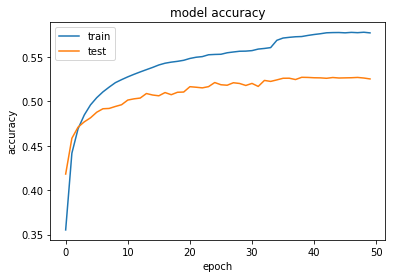

In [19]:
# Plot accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [21]:
# Evaluate model
model.evaluate(test_input, test_label)

16657/16657 [==============================] - 4s 269us/step


[5.595765549101563, 0.08110704208530355]

In [33]:
# Test model
test_sent = ["He told us a very exciting adventure story",
             "She wrote him a long letter but he did not read it",
             "The sky is clear black with shining stars",
             "I am counting my calories yet I really want dessert",
             "I saw sky and that was color blue"
            ]
for sent in  test_sent:
    sent_4_NN = sent[:30].lower()
    print(sent_4_NN)
    print(predict_completions(sent_4_NN, 5))
    print()

    

he told us a very exciting adv
['ance ', 'ice ', 'ent ', 'ocate ', 'ustion ']

she wrote him a long letter bu
['t ', 'sh ', 'reau ', 'ild ', 'nder ']

the sky is clear black with sh
['e ', 'ow ', 'are ', 'ip ', 'ure ']

i am counting my calories yet 
['and ', 'the ', 'second ', 'one ', 'in ']

i saw sky and that was color b
['y ', 'ecause ', 'ut ', 'oth ', 'ased ']

